# Cost-aware Bayesian Optimization

This tutorial covers cost-aware Bayesian optimization, a situation in which the cost of evaluation is unknown but assumed to depend on the set or a subset of the optimization parameters. 

Note that cost-aware Bayesian optimization is a more general form of multifidelity Bayesian optimization: 
* In multi-fidelity Bayesian optimization, the fidelity parameters are typically known ahead of time, an the relationship between cost and performance is typically known e.g., the highest fidelity parameters are the least noisy and the most costly. 
* In cost-aware Bayesian optimization, we do not know a-priori which parameters dictate cost, nor do we make any assumptions about the relationship between cost and performance. 

Cost-aware Bayesian optimization is well suited to any problem for which the user suspects there to be a heterogenous cost of evaluation. It can also be used as a simpler alternative to multifidelity optimization, although we recommend a dedicated multifidelity algorithm for more experienced users. In this tutorial, the acquisition function we use for cost-aware Bayesian optimization is expected improvement per unit (EIpu), which has the following formula:

$$
EIpu(x) = \frac{EI(x)}{c(x)^\alpha}
$$

$c(x)$ is a cost model that predicts the evaluation cost and $\alpha \in [0, 1]$ is a decay factor that reduces or increases the cost model's effect to prevent cheap points from dominating the optimization routine. We recommend starting $\alpha$ at 1 and decreasing it to 0 as the optimization budget is exhausted. 

[1]: [Lee, Eric Hans, et al. Cost-aware Bayesian Optimization. International Conference on Machine Learning, AutoML Workshop. 2020. ](https://arxiv.org/pdf/2003.10870.pdf)

In [1]:
import os
import time
import torch
import warnings

from abc import ABC, abstractmethod

from botorch.acquisition import AnalyticAcquisitionFunction, ExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Log
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils import standardize
from botorch.utils.sampling import draw_sobol_samples

from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tkwargs = {
    "device": device,
    "dtype": torch.double,
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")


# Cost Modeling

The first thing we do in this tutorial is define a simple cost model, in which we make no assumptions other than a positive cost. We will use the mean of a GP for the cost model. To enforce positivity, we will model the log cost and then exponentiate when we perform predictions. Users can use more bespoke cost models should they have a better understanding of their problem. 

Having defined the cost model, we'll also generate some simple plots of a 1D synthetic problem for illustrative purposes, where the objective is the Ackley function and the cost is quadratic.

In [2]:
class CostModel(torch.nn.Module, ABC):
    """
    Simple abstract class for a cost model.
    """    
    
    @abstractmethod
    def forward(self, X):
        pass
    

class CostModelGP(CostModel):
    """
    A basic cost model that assumes the cost is positive.
    It models the log cost to guarantee positive cost predictions.
    """

    def __init__(self, X, Y_cost):
        assert torch.all(Y_cost > 0)
        super().__init__()
        gp = SingleTaskGP(train_X=X, train_Y=Y_cost, outcome_transform=Log())
        mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
        fit_gpytorch_mll(mll)
        self.gp = gp

    def forward(self, X):
        return torch.exp(self.gp(X).mean)


In [3]:
def synthetic_objective_with_cost(x):
    dim = 1
    f = Ackley(dim)  # synthetic objective is the Ackley
    fx = f(x).unsqueeze(1)
    cx = 200 * (1.1 - x) ** 2  # synthetic cost is quadratric
    return fx, cx


# Generate training data
dim = 1
num = 4
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
train_X = draw_sobol_samples(bounds=bounds, n=num, q=1, seed=111).squeeze(1)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)

In [4]:
train_X.shape, train_Y.shape, cost_Y.shape

(torch.Size([4, 1]), torch.Size([4, 1]), torch.Size([4, 1]))

In [5]:
# Fit GP to data
train_Y = standardize(train_Y)
gp = SingleTaskGP(train_X=train_X, train_Y=train_Y)
mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
fit_gpytorch_mll(mll)

# Fit cost model to data
cost_model_gp = CostModelGP(train_X, cost_Y)


# Plot the GP and the Cost Model

Text(0, 0.5, 'Cost of Evaluation')

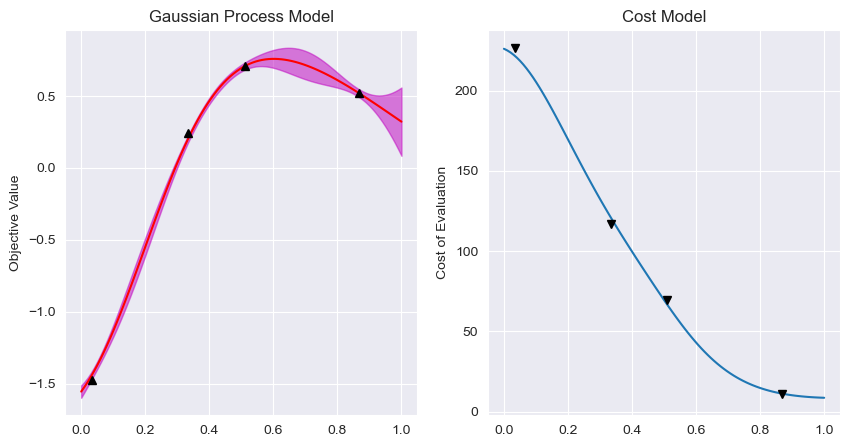

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot GP
X_preds = torch.linspace(0, 1, 100, **tkwargs).unsqueeze(1)
Y_preds = gp.posterior(X_preds)
Y_mean = Y_preds.mean.squeeze().detach().numpy()
Y_var = Y_preds.variance.squeeze().detach().numpy()
axes[0].plot(X_preds, Y_preds.mean.detach().numpy(), "r")
axes[0].plot(train_X, train_Y, "k^")
axes[0].fill_between(
    X_preds.numpy()[:, 0], Y_mean - Y_var, Y_mean + Y_var, color="m", alpha=0.5
)
axes[0].set_title("Gaussian Process Model")
axes[0].set_ylabel("Objective Value")

# Plot Cost Model
cost_preds = cost_model_gp(X_preds)     # calls forward: return torch.exp(self.gp(X).mean)
axes[1].plot(X_preds, cost_preds.detach().numpy())
axes[1].plot(train_X, cost_Y, "kv")
axes[1].set_title("Cost Model")
axes[1].set_ylabel("Cost of Evaluation")


# Expected Improvement Per Unit

Having defined the cost model, we can now define our EIpu acquisition function and plot it for different values of $\alpha$. Note that when $\alpha=0$, EIpu simply reduces to EI. 

In [7]:
class ExpectedImprovementWithCost(AnalyticAcquisitionFunction):
    """
    This is the acquisition function EI(x) / c(x) ^ alpha, where alpha is a decay
    factor that reduces or increases the emphasis of the cost model c(x).
    """

    def __init__(self, model, best_f, cost_model, alpha=1):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.ei = ExpectedImprovement(model=model, best_f=best_f)
        self.alpha = alpha

    def forward(self, X):
        return self.ei(X) / torch.pow(self.cost_model(X)[:, 0], self.alpha) # the 0 is because the cost model returns a 2D tensor


In [8]:
X_preds = torch.linspace(0, 1, 100, **tkwargs).unsqueeze(1)
X_batch = X_preds.unsqueeze(1)

# X_batch is a 3D tensor of shape (100, 1, 1), but the cost model returns a 2D tensor of shape (100, 1)
X_batch.shape, cost_model_gp(X_batch).shape

(torch.Size([100, 1, 1]), torch.Size([100, 1]))

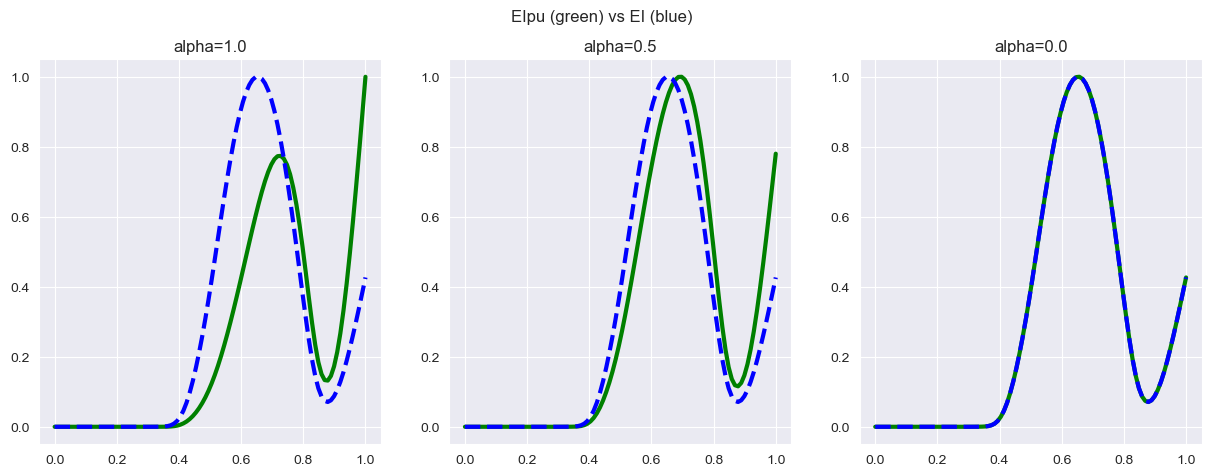

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def normalize_acquisition_values(values):
    max_value = values.max().item()
    min_value = values.min().item()
    return (values - min_value) / (max_value - min_value)


# Compute EI
fmax = torch.max(train_Y)
ei = ExpectedImprovement(model=gp, best_f=fmax)
ei_values = normalize_acquisition_values(ei(X_batch))

# Compute and plot EIpu vs EI
fig.suptitle("EIpu (green) vs EI (blue)")
for i in range(3):
    alpha = 1 - i / 2
    eipu = ExpectedImprovementWithCost(
        model=gp,
        best_f=fmax,
        cost_model=cost_model_gp,
        alpha=alpha,
    )
    eipu_values = normalize_acquisition_values(eipu(X_batch).squeeze())
    axes[i].plot(X_preds, eipu_values.detach().numpy(), "-g", linewidth=3)
    axes[i].plot(X_preds, ei_values.detach().numpy(), "--b", alpha=1, linewidth=3)
    axes[i].set_title(f"alpha={alpha}")


# A Practial Problem

To make things more interesting, let's look at the classic problem of least squares estimation:

$$
\text{arg} \min_{x \in \mathbb{R}^d} \| Ax - b \|_2
$$

$A$ is a matrix of size $n \times d$ and $b$ is a vector of length $n$. Assuming that $n \geq d$, the solution to this problem is unique and has the following closed form: $(A^T A) ^{-1} (A^T b)$. The problem with explicitly computing this solution is that it will have an $\mathcal{O}(n^3)$ complexity due to the need to compute a Cholesky factorization of the matrix $A^T A$. 


These difficulties in computing an explicit solution when $n$ is large lead us to a cost-aware twist on the least squares estimation. An alternative solution is to perform batched gradient descent by sampling rows of $A$. Because the batching introduces noise, we'll use Adam to perform the optimization. This introduces hyperparameters such as the learning rate, batch size, and the number of optimization iterations. These hyperparameters influence the cost immensely, as we'll see in a bit. 

In [10]:
class NoisyLinearLeastSquares:
    """
    The standard linear least squares problem min_x ||Ax - b||_2.
    We compute the loss via batching that introduces noise.
    """

    def __init__(self, A, b, batch_size=50):
        self.A = A
        self.b = b
        self.batch_size = min(batch_size, self.A.shape[0])

    def fit(self, lr=1, niters=100):
        x = torch.zeros(A.shape[1], 1, requires_grad=True, **tkwargs)
        optimizer = torch.optim.Adam([x], lr=lr)
        batch_indices = torch.randperm(A.shape[1])[: self.batch_size]
        for i in range(niters):
            res = torch.matmul(self.A[batch_indices, :], x) - self.b[batch_indices]
            loss = torch.norm(res)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return x, loss


# Cost Analysis

Here, we examine the variation in runtime as we vary both the batch size and the number of Adam iterations. Perhaps unsurpsingly, the runtime varies significantly with these parameters. Though we expect the runtime to be stricly linear in both the batch size and the number of Adam iterations, we can see that in practice the graph is a little variance due to the nuances in which the computer executes the matrix operations.

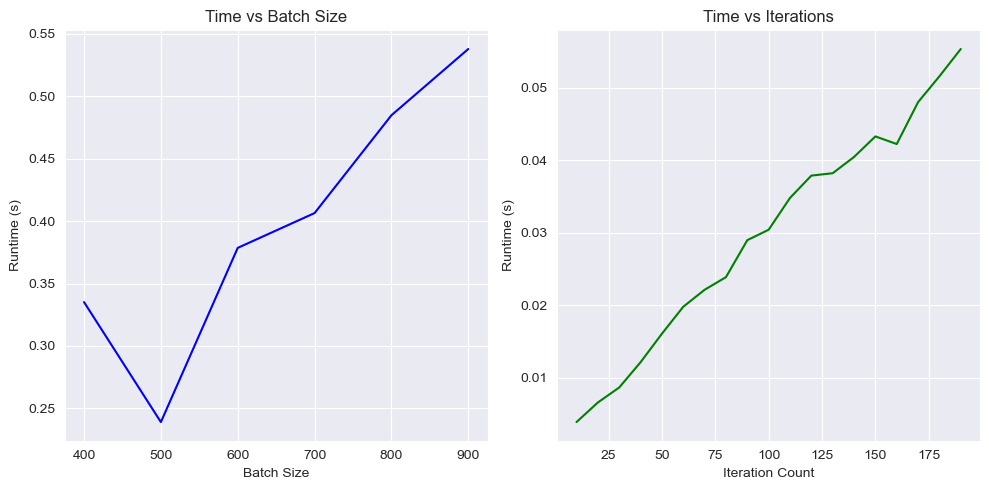

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
n = 30000 if not SMOKE_TEST else 300
d = 3000 if not SMOKE_TEST else 30
A = torch.rand(n, d, **tkwargs)
b = torch.rand(n, 1, **tkwargs)

# Timings varying batch size
batch_sizes = 100 * torch.arange(4, 10, device=device) 
times_batch = []
for batch_size in batch_sizes:
    model = NoisyLinearLeastSquares(A, b, batch_size=batch_size)
    t_start = time.time()
    model.fit(lr=0.1, niters=200)
    times_batch.append(time.time() - t_start)

axes[0].set_title("Time vs Batch Size")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Runtime (s)")
axes[0].plot(batch_sizes, times_batch, "b")

# Timings varying number of Adam iterations
iter_count = 10 * torch.arange(1, 20, device=device)
times_iters = []
for niters in iter_count:
    model = NoisyLinearLeastSquares(A, b)
    t_start = time.time()
    model.fit(lr=0.1, niters=niters)
    times_iters.append(time.time() - t_start)

axes[1].set_title("Time vs Iterations")
axes[1].set_xlabel("Iteration Count")
axes[1].set_ylabel("Runtime (s)")
axes[1].plot(iter_count, times_iters, "g")

plt.tight_layout()


# Full Optimization Loop

Having defined our problem, let's now run a full optimization loop and see how EIpu does compared to EI. Let's tune three hyperparameters in our least squares estimator: the learning rate, the batch size, and the number of adam iterations. 

* $ \textit{learning_rate} \in [0.05, 1.0]$
* $ \textit{batch_size} \in [40, 1000] $ 
* $\textit{num_iters} \in [10, 400]$. 

Previously, we mentioned that we can use bespoke cost models tailored to the specific problem to increase performance. Let's do this by replacing the generic GP cost model with a custom linear one. Note that we can only do this because we performed some cost analysis above and understand well the relationship between hyperparameters and cost. Our cost model will simply scale linearly with both the batch size and the number of iterations: 

$$Cost\big(\textit{learning_rate}, \textit{batch_size}, \textit{num_iters}\big) \propto \textit{batch_size} \times \textit{num_iters} $$ 

In [12]:
# Assume x0 is learning rate, x1 is batch_size, x2 is iterations
bounds = torch.tensor([[0.05, 40, 10], [1, 1000, 400]], **tkwargs)


def objective(x):
    learning_rate = x[0]
    batch_size = int(x[1])
    num_iters = int(x[2])
    model = NoisyLinearLeastSquares(A, b, batch_size=batch_size)
    t_start = time.time()
    x, loss = model.fit(lr=learning_rate, niters=num_iters)
    cost = time.time() - t_start
    return loss.item(), cost


# Simplified cost model based on analysis above
class LinearCostModel(CostModel):
    def __init__(self):
        super().__init__()

    # Assume x1 is batch_size, x2 is iterations
    def forward(self, X):
        return X[:, :, 1] * X[:, :, 2]


def generate_initial_data(obj, bounds, num):
    train_x = draw_sobol_samples(bounds=bounds, n=num, q=1, seed=111).squeeze(1)
    train_y = []
    cost_y = []
    for x in train_x:
        y, c = obj(x)
        train_y.append(y)
        cost_y.append(c)
    return (
        train_x,
        torch.tensor(train_y, **tkwargs).unsqueeze(-1),
        torch.tensor(cost_y, **tkwargs).unsqueeze(-1),
    )


# Generate initial data
budget = 25
num_initial = 5
init_X, init_Y, init_C = generate_initial_data(objective, bounds, num_initial)
init_X.shape, init_Y.shape, init_C.shape


(torch.Size([5, 3]), torch.Size([5, 1]), torch.Size([5, 1]))

# Run Bayesian optimization with EIpu

In [13]:
train_X = init_X
train_Y = init_Y
cost_Y = init_C

In [14]:
for i in range(budget):
    # alpha is iterating over torch.linspace(1, 0, budget). alpha is decreasing as budget is exhausted.
    alpha = (budget - i - 1) / (budget - 1)

    # Train GP
    train_Y_flip = -1 * standardize(train_Y)  # we want to minimize so we negate
    gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
    mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
    fit_gpytorch_mll(mll)

    # Train Cost Model
    cost_model = LinearCostModel()
    fmax = torch.max(train_Y_flip)
    eipu = ExpectedImprovementWithCost(
        model=gp,
        best_f=fmax,
        cost_model=cost_model,
        alpha=alpha,
    )
    new_x, acq_value = optimize_acqf(   # returns a 2D tensor of shape (q, d)
        acq_function=eipu,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=1024,
    )

    # Get objective value and cost
    new_y, cost_y = objective(new_x.squeeze())  # squeeze to remove the batch dimension

    # update training points
    train_X = torch.cat([train_X, new_x])
    train_Y = torch.cat([train_Y, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
    cost_Y = torch.cat([cost_Y, torch.tensor([cost_y], **tkwargs).unsqueeze(1)])

costs_eipu = cost_Y[:, 0]

# Get best observed value and its cost for this single run
results_ei_cost, _ = torch.cummin(train_Y, dim=0)
times_ei_cost = torch.cumsum(costs_eipu, dim=0)

train_X.shape, train_Y.shape, cost_Y.shape


(torch.Size([30, 3]), torch.Size([30, 1]), torch.Size([30, 1]))

In [15]:
train_X.shape, init_X.shape

(torch.Size([30, 3]), torch.Size([5, 3]))

# Run Bayesian optimization with EI

In [16]:
train_X = init_X
train_Y = init_Y
cost_Y = init_C

for i in range(budget):
    # Train GP
    train_Y_flip = -1 * standardize(train_Y)  # we want to minimize so we negate
    gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
    mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
    fit_gpytorch_mll(mll)

    # Train Cost Model
    fmax = torch.max(train_Y_flip)
    ei = ExpectedImprovement(gp, fmax)
    new_x, acq_value = optimize_acqf(
        acq_function=ei,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=1024,
    )

    # Get objective value and cost
    new_y, cost_y = objective(new_x.squeeze())

    # update training points
    train_X = torch.cat([train_X, new_x])
    train_Y = torch.cat([train_Y, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
    cost_Y = torch.cat([cost_Y, torch.tensor([cost_y], **tkwargs).unsqueeze(1)])

costs_ei = cost_Y[:, 0]

# Get best observed value and its cost for this single run
results_ei, _ = torch.cummin(train_Y, dim=0)
times_ei = torch.cumsum(costs_ei, dim=0)


# Plotting Results

Unlike the usual optimization progress plots, which measure performance by comparing loss to iterations, in the cost aware setting, we measure performance by comparing loss to cumulative training time. 

EIpu and EI take the same number of iterations, but we can see that EIpu takes less time to execute those iterations (and finds a better result). We've also plotted a histogram of the evaluation times on the right. We can see that because EI is not cost aware, it has a pretty even spread of evaluation costs, whereas EIpu evaluates many more cheap points. 

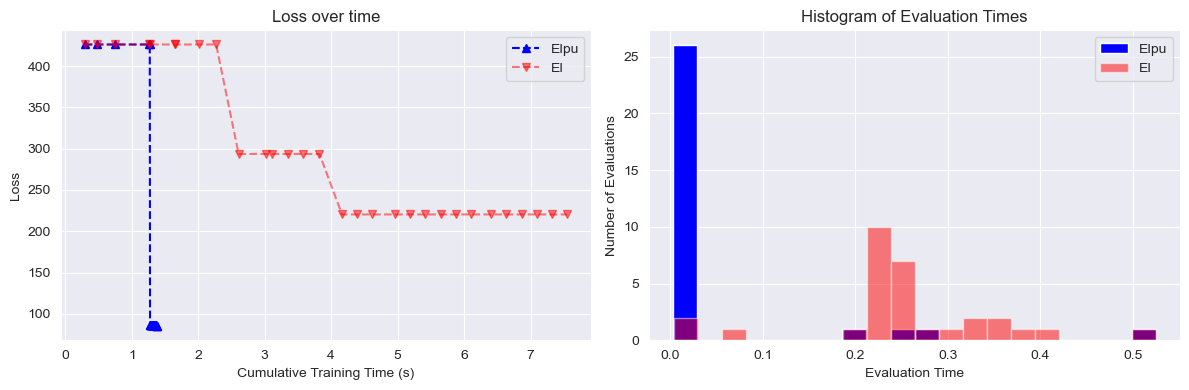

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(times_ei_cost, results_ei_cost, "--b", marker="^", label="EIpu")
axes[0].plot(times_ei, results_ei, "--r", marker="v", alpha=0.5, label="EI")
axes[0].set_xlabel("Cumulative Training Time (s)")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss over time")
axes[0].legend()

axes[1].hist(costs_eipu, bins=20, color="b", label="EIpu")
axes[1].hist(costs_ei, bins=20, color="r", alpha=0.5, label="EI")
axes[1].set_xlabel("Evaluation Time")
axes[1].set_ylabel("Number of Evaluations")
axes[1].set_title("Histogram of Evaluation Times")
axes[1].legend()

plt.tight_layout()
